<a href="https://colab.research.google.com/github/Tommo1818/CSC-345-big-data-CW1/blob/main/CSC357_Lab4_decision_making.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC357 Brain-Inspired Artificial Intelligence
## Lab 4 - Decision making

This lab will use a computational model (i.e., the drift diffusion model) to understand decision-making behaviour based on your own experimental data.

**Please note that the answers from this lab need to be uploaded as a part of the coursework of CSC357. You can find the questions at the end of this notebook.**

We will use [HSSM](https://lnccbrown.github.io/HSSM), a relatively new library for model fitting. HSSM utilizes Bayesian model fitting to analyze observed data, providing posterior distributions of model parameters for inference. While the technique details of model fitting are not the primary focus here, further information on the toolbox is available on [its website](https://lnccbrown.github.io/HSSM/).

If you are conducting this lab on Google Colab, you can leverage GPU acceleration to expedite the fitting procedure. To enable this, navigate to `Runtime` -> `Change runtime type` in the menu, and select `GPU` under `Hardware accelerator`. Note that there is a GPU usage limit on Colab.

**If you encounter an error while running the GPU version of the script, please use the standard CPU-based fitting procedure provided.** You will get the same result, just slower. This lab has not been tested on local machines with physical GPUs.

---


<a name="exp"></a>
## 1. Your own data as a decision-maker

You are going to perform a simple perceptual decision-making task. In each trial, a picture similar to the one below will be presented. All pictures were made from the [MINST database](https://en.wikipedia.org/wiki/MNIST_database) with added noise.

Your task is to decide whether the number in the picture is `3` or `5`. You make decisions by pressing the number `3` or `5` key on the keyboard.

<img src="http://ccbrain.org/images/CSC357/mnist_example.png" width="600">


**Please note that you need to respond as accurately and as fast as possible. It is ok to make some errors.**

**At the beginning of the experiment, you will be given a random participant ID. Please note the ID to download your data later.** If you run the experiment again, a different ID will be issued. You can also change your ID to another number.

Some information about the experiment:
* The task is comprised of 120 trials.
* 60 trials are easier, and 60 trials are more difficult.
* Each picture will be presented for 0.5 s.
* You have a maximum of 3 s to make each decision.
* The experiment takes approximately 8~10 minutes.


**Use this link to start your experiment [https://run.pavlovia.org/jiaxiangzhang/perceptual_decision](https://run.pavlovia.org/jiaxiangzhang/perceptual_decision).**


---



<a name="dataset"></a>
## 2. Data preprocessing and preliminary statistics

First we need to install some libraries. This may take a while.

**Note that you need to restart the session after the installation (`Runtime` --> `Restart session` from the menu).**

In [ ]:
# @title Install libraries
# !pip install numpy==1.23.4
# !pip install git+https://github.com/lnccbrown/hssm@main
!pip install git+https://github.com/brown-ccv/hddm-wfpt@main
!pip install numpyro
!pip install hssm
!pip install blackjax

  Cloning https://github.com/brown-ccv/hddm-wfpt (to revision main) to /tmp/pip-req-build-ii0bmjwi
  Running command git clone --filter=blob:none --quiet https://github.com/brown-ccv/hddm-wfpt /tmp/pip-req-build-ii0bmjwi
  Resolved https://github.com/brown-ccv/hddm-wfpt to commit 523ac6ed09cc447c6b5f08b60a59db43520c4c57
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hddm-wfpt: filename=hddm_wfpt-0.1.1-cp310-cp310-linux_x86_64.whl size=856795 sha256=f3add4c1b474b7231cfad78b394cc71ccd9049acb11fa4ac25161a6f80d10d46
  Stored in directory: /tmp/pip-ephem-wheel-cache-khdy9_xk/wheels/f2/52/35/be16db68fefdbbc0f0b5641f4b64ef83ad08ec42589fc53910
Successfully built hddm-wfpt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.2/330.2 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 M

**Note: You need to restart the Runtime after the previous step.**

After completing the experiment, your data is stored here: [https://gitlab.pavlovia.org/jiaxiangzhang/perceptual_decision/-/tree/master/data](https://gitlab.pavlovia.org/jiaxiangzhang/perceptual_decision/-/tree/master/data).

If your participant ID is **`123456`**, you should find a data file named: **`123456_main_exp_XXXXX.csv`**. The **`XXXXX`** part represents the date and time of your experiment completion.

(You may also notice a `.log.gz` file under the same participant ID, You can ignore that file).

If, for any reason, you cannot locate your result file or are unable to complete the experiment, please use the example file provided in that directory, named **`example_data.csv`**.

The preprocessing scripts below use the example data file. You will need to replace it with your own data file.

In [ ]:
ls

anscombe.json*                data_954766_main_exp_2024-04-28_15h48.56.168.csv  README.md*
california_housing_test.csv   mnist_test.csv
california_housing_train.csv  mnist_train_small.csv


In [ ]:
# @title Load data

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

"""
PATH to the raw data file. You can either use the URL or download the file to your local machine
IMPORTANT: You need to replace this file with your own data file
"""
raw_file = 'data_954766_main_exp_2024-04-28_15h48.56.168.csv'
baseDir = 'https://gitlab.pavlovia.org/jiaxiangzhang/perceptual_decision/-/raw/master/data/'


# Load the data
inFile=pd.read_csv('data_954766_main_exp_2024-04-28_15h48.56.168.csv')

# Show first few rows of the dataset
pd.set_option('display.max_columns', None)
inFile.head()

,subject.started,subject.stopped,key_resp_5.keys,key_resp_5.rt,key_resp_5.duration,participant,session,date,expName,psychopyVersion,OS,frameRate,ins.started,ins.stopped,key_instruct.keys,key_instruct.rt,key_instruct.duration,ins2.started,ins2.stopped,key_instruct_2.keys,key_instruct_2.rt,key_instruct_2.duration,in3.started,in3.stopped,key_resp_2.keys,key_resp_2.rt,key_resp_2.duration,ins4.started,ins4.stopped,key_resp_3.keys,key_resp_3.rt,key_resp_3.duration,trial_try.started,trial_try.stopped,response_2.keys,response_2.corr,response_2.rt,response_2.duration,gap.started,gap.stopped,feedback_try.started,feedback_try.stopped,practise.thisRepN,practise.thisTrialN,practise.thisN,practise.thisIndex,practise.ran,stim,difficulty,corrans,start_2.started,start_2.stopped,key_resp_4.keys,key_resp_4.rt,key_resp_4.duration,easydiff.started,easydiff.stopped,trial_2.started,trial_2.stopped,response.keys,response.corr,response.rt,response.duration,feedback.started,feedback.stopped,trials.thisRepN,trials.thisTrialN,trials.thisN,trials.thisIndex,trials.ran,finish.started,finish.stopped,key_resp_6.keys,key_resp_6.rt,key_resp_6.duration
0,0.0007,19.3061,space,19.2846,NaN,954766,1,2024-04-28_15h48.56.168,main_exp,2023.2.3,Win32,59.88024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,954766,1,2024-04-28_15h48.56.168,main_exp,2023.2.3,Win32,59.88024,19.3062,27.8528,space,8.5299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,954766,1,2024-04-28_15h48.56.168,main_exp,2023.2.3,Win32,59.88024,NaN,NaN,NaN,NaN,NaN,27.8529,37.1867,space,9.3105,0.0002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,954766,1,2024-04-28_15h48.56.168,main_exp,2023.2.3,Win32,59.88024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.1868,41.1535,space,3.9407,0.0001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,954766,1,2024-04-28_15h48.56.168,main_exp,2023.2.3,Win32,59.88024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.1535,50.8877,space,9.7136,0.0002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The data file above contains a lot of columns irrelevant to our analysis. For simplicity, we only keep three columns in a new dataset:



* **`rt`** (the response time of each trial)
* **`response`** (1: correct response; -1: incorrect response)
* **`cond`** (easy: easy trial; diff: difficult trial)

The code below stores a simplified dataset.

In [ ]:
# @title Preprocessing
dataset = pd.DataFrame().assign(rt=inFile['response.rt'],response=inFile['response.corr'], cond=inFile['difficulty'])
dataset=dataset.dropna().reset_index(drop=True)
dataset['response'] =dataset['response']*2-1

dataset.head(n=15)

,rt,response,cond
0,1.0915,1.0,easy
1,1.0048,-1.0,easy
2,1.3518,1.0,diff
3,1.7976,1.0,easy
4,1.1629,1.0,diff
5,1.2688,1.0,diff
6,1.2327,1.0,diff
7,1.1340,-1.0,diff
8,0.9258,1.0,easy
9,1.2478,1.0,diff


We can now summarize the behavioural results in terms of RT (response time) distribution and decision accuracy (proportion of correct).

In [ ]:
# @title Mean accuracy and RT
print('Accuracy in Easy condition: ' + '{:.2%}'.format(np.round(np.mean(dataset[dataset['cond']=='easy']['response']>0),2)) )
print('Accuracy in Difficult condition: ' + '{:.2%}'.format(np.round(np.mean(dataset[dataset['cond']=='diff']['response']>0),2)) )

print('RT in Easy condition: ' + '{:.3}'.format(np.mean(dataset[dataset['cond']=='easy']['rt'])) + ' s')
print('RT in Difficult condition: ' + '{:.3}'.format(np.mean(dataset[dataset['cond']=='diff']['rt'])) + ' s')

Accuracy in Easy condition: 93.00%
Accuracy in Difficult condition: 75.00%
RT in Easy condition: 0.807 s
RT in Difficult condition: 0.969 s


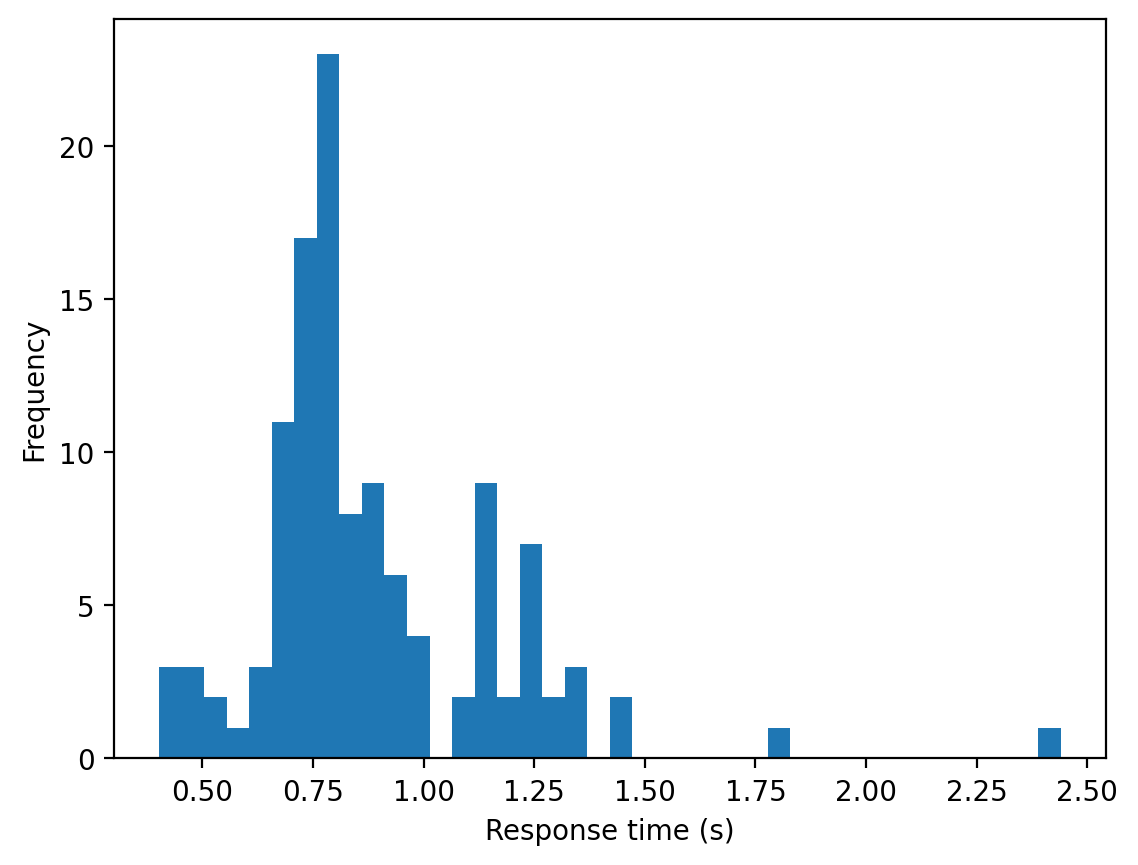

In [ ]:
# @title RT distribution
ax = dataset['rt'].plot(kind='hist', bins=40);
ax.set_xlabel('Response time (s)');

### Think
* Do the behavioural results make sense?
* Any difference in accuracy and mean RT between the easy and difficult conditions?

---


<a name="ddm"></a>
## 3. Fit the drift-diffusion model to your own data
Now, we are ready to use the drift-diffusion model to fit to the behaviorual data. That is, we seek model parameters that lead to model predictions similar to the statistics (response time distribution and accuracy) in the behaviorual data.

First, we define the model using the HSSM package.

In [ ]:
# @title 3.1 Define the model
import hssm
import arviz as az

hssm.set_floatX("float32");

param_v = {
    "name": "v",
    "formula": "v ~ 0 + cond ",}

param_z = {
    "name": "z",
    "prior": 0.5}

simple_ddm = hssm.HSSM(data=dataset,include = [param_v,param_z]);
simple_ddm

Setting PyTensor floatX type to float32.


INFO:hssm:Setting PyTensor floatX type to float32.


Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


INFO:hssm:Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 119

Parameters:

v:
    Formula: v ~ 0 + cond 
    Priors:
        v_cond ~ Normal(mu: [0. 0.], sigma: [5.0002 5.0002])
    Link: identity
    Explicit bounds: (-inf, inf)
a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)
z:
    Prior: 0.5
    Explicit bounds: (0.0, 1.0)
t:
    Prior: HalfNormal(sigma: 2.0, initval: 0.10000000149011612)
    Explicit bounds: (0.0, inf)

Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 10.0)

The code above defines a drift diffusion model for the dataset. The figure below illustrates the model and its key parameters.

<img src="https://ccbrain.org/images/CSC357/ddm.jpg" width="800">

The model assumes that for each binary decision, there is a stochastic process integrating momentary evidence over time. Once the accumulated evidence reaches a decision boundary, the process is terminated, and the decision is made. There are two boundaries, corresponding to the "correct" and "error" decisions.

The stochastic process has an average accumulation speed, termed the drift rate $v$. If $v$ > 0, the model will, on average, reach the "correct" boundary more often and is hence more likely to make correct decisions.

The distance between the two boundaries is termed boundary separation, denoted by $a$ ($a>0$.

The variable $T_{er}$ denotes the non-decision time, which refers to the time allocated to other processes such as sensorimotor latencies.

The bias parameter $z$ ($z\in (0,1)$) denotes whether the decision-maker has a prior bias towards one of the two boundaries. Here, we set $z$ as a constant $z=0.5$, meaning that there is no bias.

The code below generates a graph representation of the defined model with its prior distributions.

Further details are available from the lecture in Week 4.

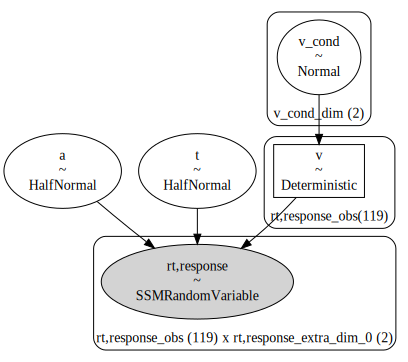

In [ ]:
# Graph representation of the defined model
simple_ddm.graph()

### 3.2 Model fitting

Given the observed data, the code below uses Markov Chain Monte Carlo to draw posterior model parameters. Two methods are available here, with one enabling accelerated calculation using GPU. If you have GPU enabled, the code will use the faster method; otherwise, it will use the standard sampling method on CPU, which typically takes 15~20 minutes on Google Colab.

You can increase the number of draws for better parameter estimates (currently set at **`draws=1500`**), at the cost of additional computational time.

In [ ]:
!pip freeze | grep jax



blackjax==1.1.1
jax==0.4.26
jaxlib @ https://storage.googleapis.com/jax-releases/cuda12/jaxlib-0.4.26+cuda12.cudnn89-cp310-cp310-manylinux2014_x86_64.whl#sha256=813cf1fe3e7ca4dbf5327d6e7b4fc8521e92d8bba073ee645ae0d5d036a25750
jaxopt==0.8.3


In [ ]:
# @title Model fitting
import tensorflow as tf
if tf.test.gpu_device_name()=='':
  print('Running sampling on CPU')
  simple_ddm.sample(sampler="mcmc", cores=1,chains=1,draws=1500,tune=500 )
else:
  print('Running sample on GPU')
  simple_ddm.sample(sampler="nuts_numpyro", cores=1,chains=1,draws=1500,tune=500 )

Running sample on GPU


ModuleNotFoundError: No module named 'jax.linear_util'

<a name="postpred"></a>
After sampling, we can check how well the model fits the experimental data, using the code below.

The figure plots RT distributions from both observed data and model prediction, separated for the easy and difficult conditions.

* The positive x-axis plots the RT distributions from all correct responses.
* The negative x-axis plots the RT distributions from all error responses.
* The distributions are normalized by the proportion of correct and error responses, such that the area under the curve sums up to 1.

If the model prediction does not fit well with the observed data, you can re-run the sampling procedure with a longer chain (larger `draws` value)

In [ ]:
# @title Model prediction

# Model predictions vs. observed data
ax = hssm.plotting.plot_posterior_predictive(simple_ddm, row="cond",range=[-3,3],bins=40);

<a name="postpar"></a>
### 3.3 Posterior model parameters

After model fitting, we can check the posterior estimates of model parameters (e.g., their means and standard deviations). This can be done in just one line. Note that we have two drift rate estimates:
* `v_cond[diff]`
* `v_cond[easy]`

This is because we defined the model to have separate drift rate estimates for the easy and difficult conditions of the experiment.

In [ ]:
# Print posterior model parameters
simple_ddm.summary()

The codes below plot the posterior distributions of the draft rates from the two experimental conditions.

**Think: What are the impact of task difficulty on the drift rate? Why?**

In [ ]:
# @title Posterior estimates of drift rates
az.plot_dist(simple_ddm.traces.posterior.sel(v_cond_dim='diff')['v_cond'], color='C0', label='cond: difficult')
az.plot_dist(simple_ddm.traces.posterior.sel(v_cond_dim='easy')['v_cond'], color='C1', label='cond: easy')
plt.ylabel('Density');
plt.title('Drift rate');
plt.legend(frameon=False);



---



## **Coursework TODO**

Using the provided scripts as a guide, please answer the following two questions, and include your answers in your coursework submission.

---


**[Q1]**. Complete the perceptual decision-making task online. You can start the task via [this link](https://run.pavlovia.org/jiaxiangzhang/perceptual_decision/). [Section 1](#exp) provides further information about the experiment. After the experiment, download and preprocess your data, using codes in [Section 2](#dataset) as examples.

### **In your coursework, include the following results from the experiment:**
* **A histogram showing the response time distribution.**
* **Mean accuracy and response time in the easy and difficult conditions, separately.**
* **A short statement on the behavioural difference (if any) between the easy and difficult conditions.**

---

**[Q2]**. Define and fit a drift-diffusion model to your behavioural data [(as in Section 3)](#ddm).

### **In your coursework, include the following results:**
* **Posterior model prediction plots together with the observed data [(as in Section 3.2)](#postpred)**
* **The means and standard deviations of the fitted model parameters [(as in Section 3.3)](#postpar)**
* **Posterior distributions of the drift rate estimates from the easy and difficult conditions**
* **A short statement on how task difficulty influences the drift rate.**